In [1]:
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset, ConcatDataset
import torch.nn as nn
import torchvision
import torch
from torch import optim
# resnet默认图片输入大小为224*224*3

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.resnet = torchvision.models.resnet18(pretrained=False)  
        #pretrained=True代表使用预训练的模型
    def forward(self, x):
        x= self.resnet(x)
        return x

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
data_root = './autodl-tmp/fashion-mnist'
data_train = FashionMNIST(data_root,
                   train=True,
                   download=True,
                   transform=transforms.Compose([
                       transforms.Resize((224, 224)),
                       transforms.ToTensor(),
                       transforms.Lambda(lambda x: x.repeat(3,1,1)),
                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]))
data_test = FashionMNIST(data_root,
                  train=False,
                  download=True,
                  transform=transforms.Compose([
                       transforms.Resize((224, 224)),
                       transforms.ToTensor(),
                       transforms.Lambda(lambda x: x.repeat(3,1,1)),
                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]))

In [3]:
data_train_loader = DataLoader(data_train, batch_size=256, shuffle=True, num_workers=8)
data_test_loader = DataLoader(data_test, batch_size=256, num_workers=8)

In [4]:
net = torchvision.models.resnet18(pretrained=False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)  #2e-3会立马收敛

In [5]:
def train(epoch):
    global cur_batch_win
    net.train()
    loss_list, batch_list = [], []
    total_correct = 0
    for i, (images, labels) in enumerate(data_train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss_list.append(loss.detach().cpu().item())
        batch_list.append(i+1)
        pred = output.detach().max(1)[1]
        total_correct += pred.eq(labels.view_as(pred)).sum()
        # if i % 10 == 0:
            # print('Train - Epoch %d, Batch: %d, Loss: %f' % (epoch, i, loss.detach().cpu().item()))
        loss.backward()
        optimizer.step()
    avg_loss = sum(loss_list) / len(loss_list)
    acc = float(total_correct) / len(data_train)
    print('Train Avg. Loss: %f, Accuracy: %f' % (avg_loss, acc))
    return acc, avg_loss

In [6]:
def test():
    net.eval()
    batch_list = []
    with torch.no_grad():
        total_correct = 0
        avg_loss = 0.0
        for i, (images, labels) in enumerate(data_test_loader):
            images = images.to(device)
            labels = labels.to(device)
            output = net(images)
            avg_loss += criterion(output, labels).sum()
            pred = output.detach().max(1)[1]
            total_correct += pred.eq(labels.view_as(pred)).sum()
            batch_list.append(i+1)

    avg_loss /= batch_list[-1]
    avg_loss = avg_loss.detach().cpu().item()
    acc = float(total_correct) / len(data_test)
    print('Test Avg. Loss: %f, Accuracy: %f' % (avg_loss, acc))
    return acc, avg_loss

In [7]:
def train_and_test(epoch):
    print('training...')
    acc, loss = train(epoch)
    val_acc, val_loss = test()
    return acc, loss, val_acc, val_loss

In [8]:
epoch = 100
acc, loss, val_acc, val_loss = [], [], [], []

for e in range(epoch):
    a, b, c, d = train_and_test(e)
    acc.append(a)
    loss.append(b)
    val_acc.append(c)
    val_loss.append(d)
    print(f'lenet_epoch={e} test_acc={c:0.3f}')

training...
Train Avg. Loss: 0.812749, Accuracy: 0.796167
Test Avg. Loss: 0.553145, Accuracy: 0.805600
lenet_epoch=0 test_acc=0.806
training...
Train Avg. Loss: 0.286860, Accuracy: 0.897700
Test Avg. Loss: 0.494802, Accuracy: 0.819100
lenet_epoch=1 test_acc=0.819
training...
Train Avg. Loss: 0.227267, Accuracy: 0.919133
Test Avg. Loss: 0.293488, Accuracy: 0.893600
lenet_epoch=2 test_acc=0.894
training...
Train Avg. Loss: 0.185482, Accuracy: 0.934467
Test Avg. Loss: 0.298415, Accuracy: 0.896700
lenet_epoch=3 test_acc=0.897
training...
Train Avg. Loss: 0.149734, Accuracy: 0.946817
Test Avg. Loss: 0.589973, Accuracy: 0.810900
lenet_epoch=4 test_acc=0.811
training...
Train Avg. Loss: 0.115882, Accuracy: 0.960183
Test Avg. Loss: 0.376304, Accuracy: 0.887400
lenet_epoch=5 test_acc=0.887
training...
Train Avg. Loss: 0.091591, Accuracy: 0.968500
Test Avg. Loss: 0.300694, Accuracy: 0.904700
lenet_epoch=6 test_acc=0.905
training...
Train Avg. Loss: 0.066984, Accuracy: 0.978033
Test Avg. Loss: 0.

In [20]:
val_loss[0] += 0.1


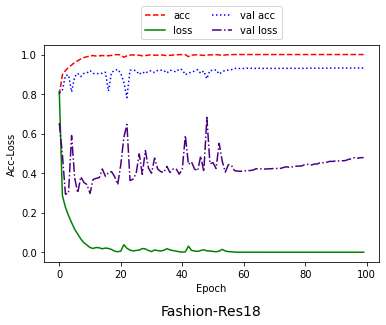

In [21]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(epoch)
plt.plot(x, acc, color='red', linestyle='--', label="acc")
plt.plot(x, loss, color='green', label="loss")
plt.plot(x, val_acc, color='blue', linestyle='dotted', label="val acc")
plt.plot(x, val_loss, color='indigo', linestyle='dashdot', label="val loss")
plt.title('Fashion-Res18', fontsize=14, y=-0.27)
plt.xlabel('Epoch')
plt.ylabel('Acc-Loss')
plt.xticks(ticks=[0,20,40,60,80,100])
# 添加图例
plt.legend(loc='center',bbox_to_anchor=(0.5, 1.1),ncol=2)
plt.show()

In [22]:
val_loss

[0.6531453490257263,
 0.49480190873146057,
 0.2934882342815399,
 0.2984151840209961,
 0.5899726748466492,
 0.3763035237789154,
 0.3006943166255951,
 0.38132715225219727,
 0.353000670671463,
 0.3420940637588501,
 0.29711994528770447,
 0.3683760166168213,
 0.37364059686660767,
 0.377151221036911,
 0.420948326587677,
 0.3838343024253845,
 0.4028352856636047,
 0.40767285227775574,
 0.3822067677974701,
 0.34231266379356384,
 0.44270434975624084,
 0.58098965883255,
 0.6460790395736694,
 0.3622269332408905,
 0.3698974549770355,
 0.3984414041042328,
 0.49749308824539185,
 0.394092321395874,
 0.514483630657196,
 0.42525315284729004,
 0.39991649985313416,
 0.4761623442173004,
 0.42118096351623535,
 0.40772801637649536,
 0.4034341275691986,
 0.43414410948753357,
 0.40320029854774475,
 0.42050060629844666,
 0.42217588424682617,
 0.3947642743587494,
 0.41846057772636414,
 0.5906859040260315,
 0.4441957473754883,
 0.4570002257823944,
 0.42039427161216736,
 0.4118879735469818,
 0.4865747094154358,
 0